In [65]:
import os
import csv
import random
import string
import sklearn
import logging
import sys
from collections import Counter
import numpy as np
from pprint import pprint
from sklearn import cross_validation,datasets
from sklearn.grid_search import GridSearchCV
from optparse import OptionParser
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer,HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier,Perceptron,PassiveAggressiveClassifier,RidgeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, adjusted_mutual_info_score, roc_auc_score, mutual_info_score, make_scorer, roc_curve,accuracy_score
from sklearn.tree import DecisionTreeClassifier


def get_file_path(filename):
    currentdirpath = os.getcwd()
    file_path = os.path.join(os.getcwd(), filename)
    return file_path

def read_csv(filepath,i):
    name = []
    with open(filepath, "rU") as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)
        for row in reader:
            if len(row) == 0:
                continue
            name.append(row[i])
    return name

#read text file
filename = "/Users/zhongyi/Documents/python/luo/Analysis_R1R2_replaced.csv"
filename2 = "/Users/zhongyi/Documents/python/luo/CandidatePatterns.csv"
path = get_file_path(filename)
path2 = get_file_path(filename2)
print path
print path2

#read csv and put all text into list
all_text = read_csv(path, 2)#list
row_name = read_csv(path, 0)#list
Candidate_pattern= read_csv(path2, 0)#list
evidence_ID = read_csv(path2, 2)#list

#remove the pattern which has evidence less than 8
useful_pattern = []
useful_evidence = []
for j in range(0,len(evidence_ID)):
    evidence = evidence_ID[j].split(",")
    if len(evidence) > 8:
        useful_evidence.append(evidence_ID[j])
        useful_pattern.append(Candidate_pattern[j])

#match row_name with evidence
wholetext = []
wholepattern = []
for i in range(0, len(row_name)):
    for number_list in range(0,len(useful_evidence)):
        evidence = useful_evidence[number_list].split(",")
        for item in evidence:
            if str(row_name[i].strip()) == item.strip():
                wholetext.append(all_text[i])
                wholepattern.append(useful_pattern[number_list])
            else:
                continue
#make sure each pattern is 7/3 
patternlist = []
for i in range(0,len(wholepattern)):
    if wholepattern[i] not in patternlist:
        patternlist.append(wholepattern[i])
    else:
        continue

match = {}
for i in range(0,8):
    a = []
    match[patternlist[i]] = a
    for j in range(0,len(wholepattern)):
        if wholepattern[j] == patternlist[i]:
            a.append(j)
print match



random.seed(1234)
all_train_pattern = []
all_train_text = []
all_test_pattern = []
all_test_text = []
for key in match:
    lista = random.sample(match[key],int(round(0.7*len(match[key]))))
    c_list = [x for x in match[key] if x not in lista]
    for i in lista:
        all_train_pattern.append(wholepattern[i])
        all_train_text.append(wholetext[i])
    for j in c_list:
        all_test_pattern.append(wholepattern[j])
        all_test_text.append(wholetext[j])
print ("train set number")
print len(all_train_pattern)
print ("test set number")
print len(all_test_pattern)

#token
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')#remove the stop words
X_train = vectorizer.fit_transform(all_train_text)
X_test = vectorizer.transform(all_test_text)
pattern = list(set(all_train_pattern))
print ("all patterns")
print pattern

/Users/zhongyi/Documents/python/luo/Analysis_R1R2_replaced.csv
/Users/zhongyi/Documents/python/luo/CandidatePatterns.csv
{'Medication Details': [20, 21, 29, 42, 44, 49, 64, 68, 76, 77, 78], 'Where Did It Happen?': [22, 23, 40, 41, 48, 55, 61, 75, 79], 'Confirm Disease Was Checked': [4, 5, 11, 12, 24, 38, 60, 65, 69], 'Rule of N': [8, 17, 18, 19, 26, 28, 33, 52, 56, 58, 63, 71, 74], 'Level of Evidence': [2, 3, 6, 31, 32, 35, 39, 57, 59], 'Credentials of the Actor': [0, 1, 13, 14, 15, 45, 50, 66, 70], 'Use Distinct Dates': [7, 9, 16, 25, 47, 51, 54, 62, 67, 72, 73], 'Check For Negation': [10, 27, 30, 34, 36, 37, 43, 46, 53, 80]}
train set number
56
test set number
25
all patterns
['Medication Details', 'Confirm Disease Was Checked', 'Rule of N', 'Use Distinct Dates', 'Level of Evidence', 'Credentials of the Actor', 'Where Did It Happen?', 'Check For Negation']


In [100]:
def fit(clf,parameter):
    scorelist = []
    for i in parameter:
        fit = clf(C=i).fit(X_train,all_train_pattern)
        pred = fit.predict(X_test)  
        score = accuracy_score(all_test_pattern, pred)
        scorelist.append(score)
    return scorelist

def plot(x,y,xlabel,ylabel,title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    ax.plot(x,y, mfc='orange', mec='orange', marker='.')
    # using 'spines', new in Matplotlib 1.0
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.axhline(linewidth=2, color='blue')
    ax.axvline(linewidth=2, color='blue')
    return fig

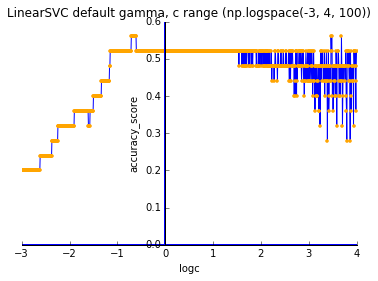

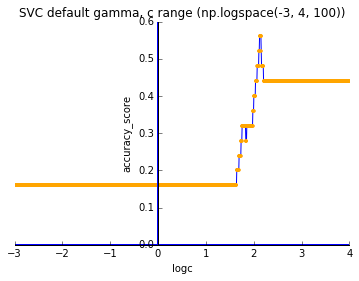

In [85]:
C_range = np.logspace(-3, 4, 1000)
logc = log10(C_range)

from matplotlib.backends.backend_pdf import PdfPages
    

#plot linear svc, tune c
scorelist = fit(LinearSVC,C_range)
summary = "LinearSVC default gamma, c range (np.logspace(-3, 4, 100))"
a = plot(logc,scorelist,"logc","accuracy_score",summary)
pp = PdfPages('linearSVC.pdf')
pp.savefig(a)
pp.close()
#plot svc, tune c
scorelist = fit(SVC,C_range)
summary = "SVC default gamma, c range (np.logspace(-3, 4, 100))"
a = plot(logc,scorelist,"logc","accuracy_score",summary)
pp = PdfPages('SVC.pdf')
pp.savefig(a)
pp.close()
#    

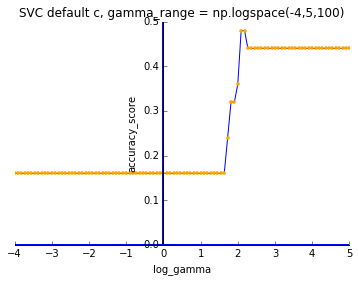

In [92]:
gamma_range = np.logspace(-4,5,100)
log_gamma = log10(gamma_range)
scorelist = fit(SVC,gamma_range)
summary = "SVC default c, gamma_range = np.logspace(-4,5,100)"
a = plot(log_gamma,scorelist,"log_gamma","accuracy_score",summary)
pp = PdfPages('SVC_gamma.pdf')
pp.savefig(a)
pp.close()

In [128]:
def fit(clf,parameter,functype):
    scorelist = []
    for i in parameter:
        if functype == "C_range":
            fit = clf(C=i).fit(X_train,all_train_pattern) 
        if functype == "gamma_range":
            fit = clf(gamma=i).fit(X_train,all_train_pattern) 
        if functype == "RandomForestClassifier":
            fit = clf(n_estimators=i).fit(X_train,all_train_pattern)
        if functype == "DecisionTreeClassifier":
            fit = clf(random_state=i).fit(X_train,all_train_pattern)
        if functype == "MultinomialNB":
            fit = clf(alpha=i).fit(X_train,all_train_pattern)
        if functype == "KNeighborsClassifier":
            fit = clf(n_neighbors=i).fit(X_train,all_train_pattern)
        pred = fit.predict(X_test)  
        score = accuracy_score(all_test_pattern, pred)
        scorelist.append(score)
    return scorelist

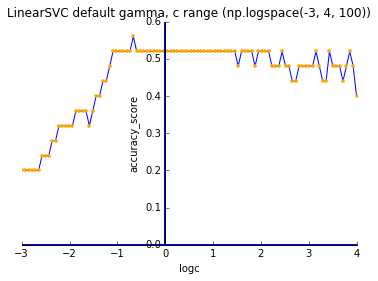

In [130]:
C_range = np.logspace(-3, 4, 100)
logc = log10(C_range)
#plot linear svc, tune c
scorelist = fit(LinearSVC,C_range,"C_range")
summary = "LinearSVC default gamma, c range (np.logspace(-3, 4, 100))"
a = plot(logc,scorelist,"logc","accuracy_score",summary)
pp = PdfPages('linearSVC.pdf')
pp.savefig(a)
pp.close()

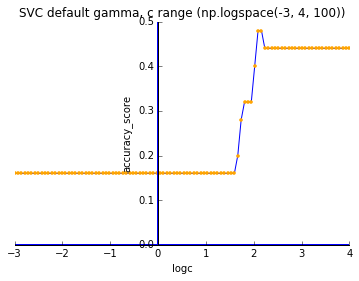

In [131]:
#plot svc, tune c
scorelist = fit(SVC,C_range,"C_range")
summary = "SVC default gamma, c range (np.logspace(-3, 4, 100))"
a = plot(logc,scorelist,"logc","accuracy_score",summary)
pp = PdfPages('SVC.pdf')
pp.savefig(a)
pp.close()

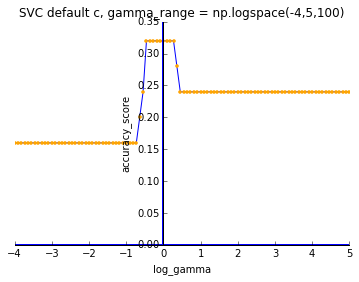

In [132]:

#plot svc tune gamma
gamma_range = np.logspace(-4,5,100)
log_gamma = log10(gamma_range)
scorelist = fit(SVC,gamma_range,"gamma_range")
summary = "SVC default c, gamma_range = np.logspace(-4,5,100)"
a = plot(log_gamma,scorelist,"log_gamma","accuracy_score",summary)
pp = PdfPages('SVC_gamma.pdf')
pp.savefig(a)
pp.close()

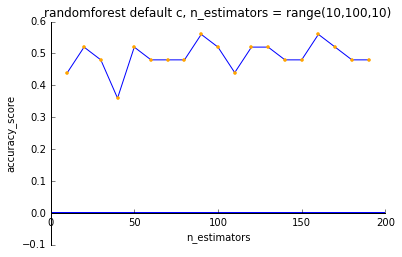

In [133]:
n_estimators = range(10,200,10)
scorelist = fit(RandomForestClassifier,n_estimators,"RandomForestClassifier")
summary = "randomforest default c, n_estimators = range(10,100,10)"
a = plot(n_estimators,scorelist,"n_estimators","accuracy_score",summary)
pp = PdfPages('RandomForestClassifier.pdf')
pp.savefig(a)
pp.close()


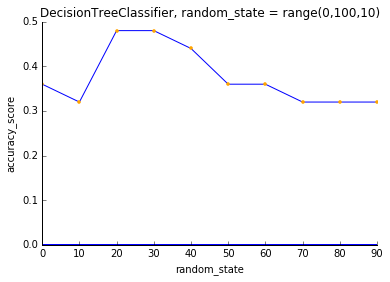

In [134]:
random_state = range(0,100,10)
scorelist = fit(DecisionTreeClassifier,random_state,"DecisionTreeClassifier")
summary = "DecisionTreeClassifier, random_state = range(0,100,10)"
a = plot(random_state,scorelist,"random_state","accuracy_score",summary)
pp = PdfPages('DecisionTreeClassifier.pdf')
pp.savefig(a)
pp.close()

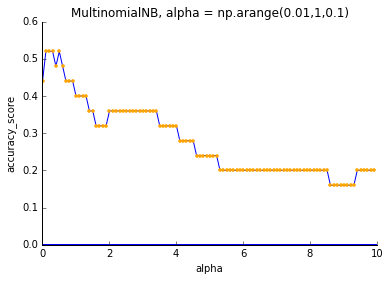

In [135]:


alpha = np.arange(0.01,10,0.1)
scorelist = fit(MultinomialNB, alpha,"MultinomialNB")
summary = "MultinomialNB, alpha = np.arange(0.01,1,0.1)"
a = plot(alpha,scorelist,"alpha","accuracy_score",summary)
pp = PdfPages('MultinomialNB.pdf')
pp.savefig(a)
pp.close()



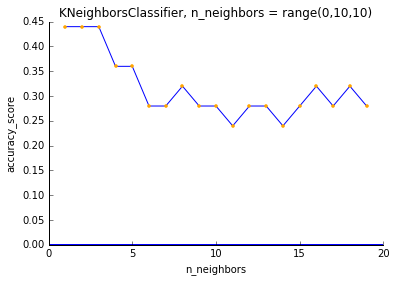

In [136]:
n_neighbors = range(1,20,1)
scorelist = fit(KNeighborsClassifier, n_neighbors,"KNeighborsClassifier")
summary = "KNeighborsClassifier, n_neighbors = range(0,10,10)"
a = plot(n_neighbors,scorelist,"n_neighbors","accuracy_score",summary)
pp = PdfPages('KNeighborsClassifier.pdf')
pp.savefig(a)
pp.close()